## Raw Data API Basic Usage in Python

<a href="https://colab.research.google.com/github/kshitijrajsharma/raw-data-api/blob/develop/Raw_Data_API_Basic_Use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 97.9 MB/s eta 0:00:00


In [3]:
import requests
import json
import time
import geopandas as gpd

## Define your API Endpoint 
### Create your payload with your geometry and learn more about payload in API docs , API_URL/docs

In [4]:
# defining the api-endpoint
BASE_API_URL = 'https://raw-data-api0.hotosm.org/v1'

payload = {
  "outputType": "geojson",
  "fileName": "My_Export",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          83.96919250488281,
          28.194446860487773
        ],
        [
          83.99751663208006,
          28.194446860487773
        ],
        [
          83.99751663208006,
          28.214869548073377
        ],
        [
          83.96919250488281,
          28.214869548073377
        ],
        [
          83.96919250488281,
          28.194446860487773
        ]
      ]
    ]
  },
  "filters": {
    "tags": {
      "all_geometry": {
        "join_or": {
          "building": ["yes"]
        }
      }
    },
  },
  "geometryType": [
    "point",
    "polygon"
  ]
}

## Call API 
### Make API call , Wait for api to finish its work poll its status

In [5]:
headers = {'accept': "application/json","Content-Type": "application/json"}

# making call to the api to get boundary
task_response = requests.post(url = f"{BASE_API_URL}/snapshot/", data = json.dumps(payload),headers=headers)

task_response.raise_for_status()
result = task_response.json() # I will be on queue and it gives my unique task_id and link to track it
print(result)
task_track_url = result['track_link']
stop_loop = False
while not stop_loop:
  check_result = requests.get(url=f"{BASE_API_URL}{task_track_url}")
  check_result.raise_for_status()
  res=check_result.json() # status will tell current status of your task after it turns to success it will give result
  if res['status'] == 'SUCCESS'or res['status'] == 'FAILED':
    stop_loop= True
  time.sleep(1) # check each second
print(res)

{'task_id': 'c99410eb-6e1a-4f2d-a9a9-3ff1366bfa54', 'track_link': '/tasks/status/c99410eb-6e1a-4f2d-a9a9-3ff1366bfa54/'}
{'id': 'c99410eb-6e1a-4f2d-a9a9-3ff1366bfa54', 'status': 'SUCCESS', 'result': {'download_url': 'https://s3.us-east-1.amazonaws.com/exports-stage.hotosm.org/My_Export_geojson_uid_c99410eb-6e1a-4f2d-a9a9-3ff1366bfa54.zip', 'file_name': 'My_Export', 'process_time': '0:00:01.942589', 'query_area': '6.32 Sq Km', 'binded_file_size': '4.01 MB', 'zip_file_size_bytes': 611822}}


## Process API 
### Open file , read , do rest of your stuff

                    geometry      osm_id  version  \
0  POINT (83.97121 28.21362)  5458684667        3   
1  POINT (83.97382 28.21318)  5459073951        1   

                                                tags  changeset  \
0  {'name': 'Lucky Traders and Suppliers', 'offic...  126759979   
1  {'name': 'Jay Gururdev Real State PVT.LTD.', '...   56932406   

             timestamp  
0  2022-09-29T03:06:54  
1  2018-03-06T11:40:02  


<Axes: >

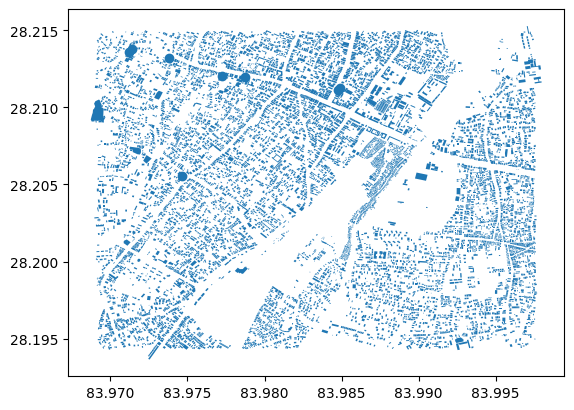

In [6]:
import io
import urllib.request
import zipfile

# Download the zip file from the URL
url = res['result']['download_url']
response = urllib.request.urlopen(url)

# Open the zip file from the response data
with zipfile.ZipFile(io.BytesIO(response.read()), 'r') as zip_ref:
    with zip_ref.open('My_Export.geojson') as file:
        my_export_geojson=json.loads(file.read())

df = gpd.GeoDataFrame.from_features(my_export_geojson['features'])
print(df.head(2))
df.plot()